# Hierarchical clustering
Based on the keywords given to articles by OpenAlex. see also: https://docs.openalex.org/api-entities/keywords

The data prepared in 01_Clean has been augmented with boolean keyword columns, one column for each keyword. Apply hierarchical clustering to these keywords, to identify structure in the dataset.

In [1]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import pandas as pd
import os
from matplotlib import pyplot as plt 
    
%matplotlib inline

In [2]:
DATA_PATH = 'data'  # path to folder with (downloaded or generated) data, will not be committed to git
ACRONYM = 'openalex_tng'  # Acronym, aka machine readable name, of this dataset ('tng' stands for "topic netework graph")

In [3]:
# load the data
clean_df = pd.read_csv(os.path.join(DATA_PATH, f"{ACRONYM}_clean.csv.zip"), index_col=0)

### Clustering
1. Extract the keyword columns into a separate dataframe 
2. Linkage method computes distance matrix
3. Create dendrogram
4. fcluster assigns cluster labels to rows.

#### Extract the keyword columns into a separate dataframe 

In [4]:
# keyword columns
colnames = clean_df.columns[14: -34]
keywords_df = clean_df.loc[:, colnames]

#### Linkage method computes distance matrix
* Distance metric: Using 'cityblock' (aka manhattan distance) instead of default 'euclidean', as keyword columns are boolean.
* Clustering method: As using non-euclidean distance, method 'single' is applied to clustering.

In [5]:
# compute distance matrix Z
Z = linkage(keywords_df, method = 'complete', metric = 'cityblock', optimal_ordering=True)

#### Create dendrogram
* x-axis: distance between clusters
* y-axis: dissimilarity between clusters
  

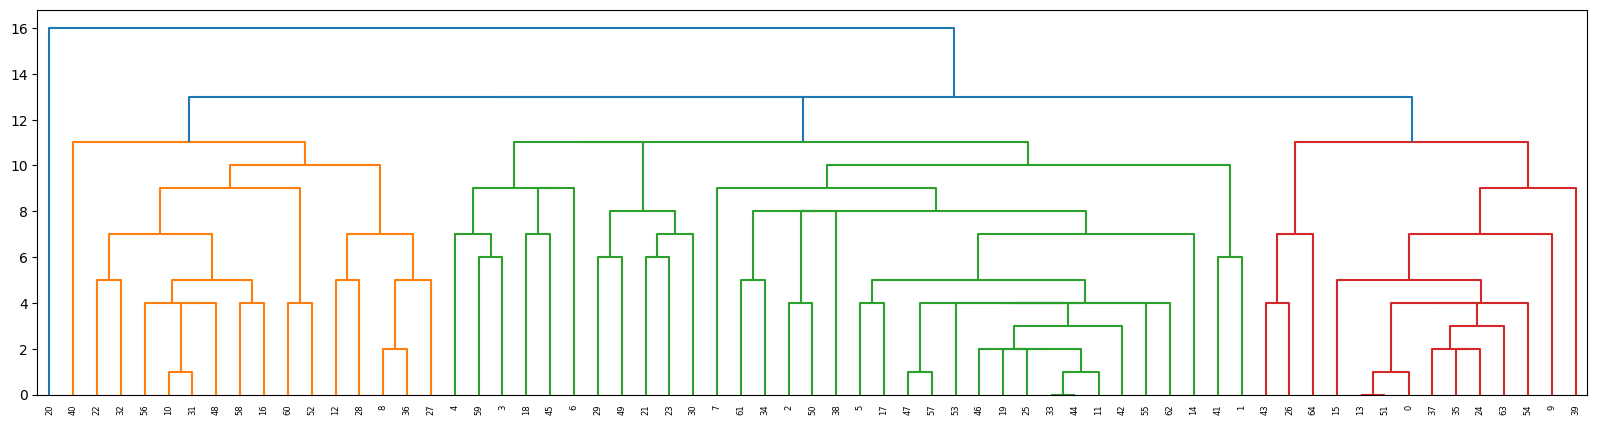

In [32]:
dn = dendrogram(Z)
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

#### fcluster assigns cluster labels to rows

In [7]:
clean_df['cluster_label'] = fcluster(Z, 4, criterion='maxclust')
clean_df.groupby('cluster_label').size()

cluster_label
1    16
2    34
3    14
4     1
dtype: int64

## Label each cluster
* Count occurrences of keywords by cluster
* Use LLM to label each cluster based on keywords

In [30]:
cluster_labels = clean_df['cluster_label'].unique()
label_keywords = {}
for label in cluster_labels:
    # get all articles with this label
    idx = clean_df['cluster_label'] == label
    articles_by_label = clean_df[idx]
    # count occurrences of keywords for articles by label
    keywords_df = articles_by_label.loc[:, colnames]  # colnames = names of keyword columns
    keywords_counts = keywords_df.sum().sort_values(ascending=False)
    # keep only entries with at least 1  occurrence
    keywords_counts = keywords_counts[keywords_counts > 0]
    label_keywords[label]= keywords_counts

In [55]:
# For each label, concatenate the keywords as a comma-sparated string (ordered by count ascending)
label_strings = {label:', '.join(keywords.index) for label,keywords in label_keywords.items()}